In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.autograd import Variable

In [2]:
%run Accuracy_Module.py
%run DataLoading.py
%run load_and_organize_dataset.py

In [ ]:
!apt-get install p7zip-full
!p7zip -d UTKFace.tar.gz
!tar -xvf UTKFace.tar.gz

In [ ]:
in_path = 'UTKFace/'
out_path = 'Data/'

count = organize_files(in_path, out_path, 1, 95)

In [3]:
resnet = models.resnet152(pretrained=True)
resnet.fc = nn.Linear(2048, 95, bias=True)
# resnet.fc = nn.Sequential(
#     nn.Linear(2048, 1024, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.2),
#     nn.Linear(1024, 512, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.2),
#     nn.Linear(512, 256, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.2),
#     nn.Linear(256, 95, bias=True)
# )

In [ ]:
resnet.cuda()
resnet.train()

In [4]:
def evaluate(net, data_loader, criterion):
    total_epoch = 0
    total_loss = 0.0
    
    for inputs, labels in data_loader:
        outputs = net(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.long().cuda())
        total_loss += loss.item()
        total_epoch += len(labels)
        
    return total_loss/total_epoch

In [5]:
def predict(model_outputs):
    pred = []
    smax = nn.Softmax(dim=1)
    prob = smax(model_outputs)

    for i in range(prob.shape[0]):
        temp = torch.Tensor([(v+1)*k for v,k in enumerate(prob[i])])
        pred.append(temp.sum())
        
    return torch.Tensor(pred)

In [6]:
def get_accuracy(net, data):
    c=0
    mean = 0.0
    for imgs, labels in data:
        mean += labels.sum()
        c+=32
    mean = (mean/c).float()
    
    ss_reg = 0
    ss_total = 0
    
    for imgs, labels in data:
        labels = labels.float() + 1
        output = net(imgs.cuda())
        pred = predict(output)
        
        ss_reg += ((labels - pred)**2).sum()
        ss_total += ((labels - mean)**2).sum()
    
    return 1 - ss_reg/ss_total

In [7]:
def get_off_accuracy(net, data_loader):
    p=0
    freq_pos = np.zeros(81)
    freq_neg = np.zeros(80)
    
    for img, label in data_loader:
        out = net(img.cuda())
        pred = predict(out)
        pred = pred.float()
             
        for i in range(0, len(label)):
            diff = label[i] + 1 - pred[i].long()
            
            if diff >= 0:
                freq_pos[diff] += 1
            else:
                freq_neg[diff] += 1

    freq_total = np.concatenate((freq_neg, freq_pos))
    freq_total = freq_total/freq_total.sum()

    diffs = []
    for n in range(-80, 81):
        diffs.append(n)

    plt.bar(diffs[50:110], freq_total[50:110])
    plt.title("Distribution of Actual-Prediction")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    print("+/- 1 years accuracy: {:.2f}%".format(freq_total[79:81].sum()*100))
    print("+/- 5 years accuracy: {:.2f}%".format(freq_total[75:86].sum()*100))
    print("+/- 10 years accuracy: {:.2f}%".format(freq_total[70:91].sum()*100))
    

In [8]:
def train_net(net, batch_size=32, learning_rate=1e-5, num_epochs=5, starting_epoch=0):
    torch.manual_seed(1000)
    
    train_loader, val_loader, test_loader = load_dataset(32)
    
    criterion = nn.CrossEntropyLoss().cuda()          
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

    start_time = time.time()
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        total_epoch = 0
        total_train_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            
            outputs = net(inputs.cuda())
             
            loss = criterion(outputs.cuda(), labels.long().cuda())
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            total_epoch += len(labels)
            
            if i % 100 == 0:
                print(i)

        model_path = get_model_name("Resnet152", batch_size, learning_rate, epoch+starting_epoch+1)
        torch.save(net.state_dict(), model_path)
        
        train_loss.append(float(total_train_loss)/total_epoch)
        val_loss.append(evaluate(net, val_loader, criterion))
        train_acc.append(get_accuracy(net, train_loader))
        val_acc.append(get_accuracy(net, val_loader))
            
        print("Epoch: {}, Training Loss: {:.3f}, Validation Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Accuracy: {:.3f}"
              .format(epoch+starting_epoch+1, train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1]))

        np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
        np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    
    print('Finished Training')
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

In [9]:
def plot_training_curve(path, num_epochs, starting_epoch = 0):
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    
    epochs = np.arange(1, num_epochs + 1 - starting_epoch)
    
    plt.title("Training vs. Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Training vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
train_net(resnet, batch_size=32, learning_rate=1e-5, num_epochs=10, starting_epoch=7)

In [ ]:
path = get_model_name("Resnet152", 32, 1e-5, 3)
plot_training_curve(path, 3, 0)

In [10]:
resnet.load_state_dict(torch.load(get_model_name("Resnet152", 32, 1e-05, 8)))
resnet.cuda()
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [11]:
train_loader, val_loader, test_loader = load_dataset(32)

In [12]:
get_accuracy(resnet, test_loader)

tensor(0.8638)

In [ ]:
get_accuracy(resnet, val_loader)

In [ ]:
get_accuracy(resnet, train_loader)

+/- 1 years accuracy: 21.57%
+/- 5 years accuracy: 68.18%
+/- 10 years accuracy: 88.41%


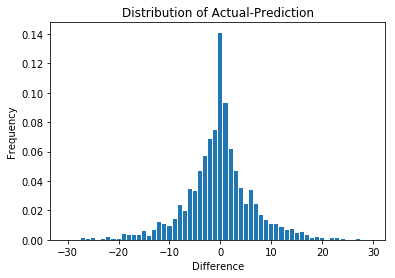

In [13]:
get_off_accuracy(resnet, test_loader)

In [ ]:
get_off_accuracy(resnet, val_loader)

In [ ]:
get_off_accuracy(resnet, train_loader)

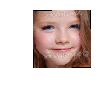

tensor(7) tensor(8.)


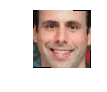

tensor(38) tensor(32.)


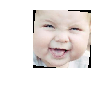

tensor(1) tensor(1.)


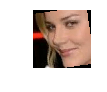

tensor(26) tensor(32.)


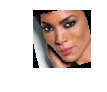

tensor(35) tensor(31.)


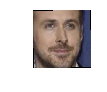

tensor(31) tensor(34.)


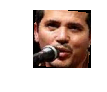

tensor(36) tensor(35.)


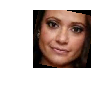

tensor(26) tensor(30.)


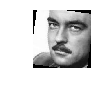

tensor(32) tensor(40.)


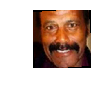

tensor(55) tensor(52.)


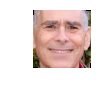

tensor(51) tensor(59.)


In [17]:
k = 0
for image, label in test_loader:
    img = image[0]
    img = np.transpose(img, [1,2,0])
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    k += 1
    print(label[0]+1, np.round(predict(resnet(image.cuda()))[0]))
    if k > 10:
        break